In [17]:
import opendatasets as od

In [18]:
od.download("https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

Skipping, found downloaded files in "./gtsrb-german-traffic-sign" (use force=True to force download)


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Any,Tuple,Optional,Callable

import os
import pathlib
import csv


import PIL
from PIL import Image

import torch
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn as nn

from torch.optim import Adam,lr_scheduler

np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

### Custom dataset

In [20]:
class GTSRB(Dataset):
    def __init__(self,
                 root: str,
                 split: str,
                 transform: Optional[Callable] = None):
        
        self.base_folder = pathlib.Path(root)
        self.csv_file = self.base_folder / ('Train.csv' if split =='train' else 'Test.csv')
        
        with open('/'+str(self.csv_file)) as csvfile:
           samples = [('/'+str(self.base_folder / row['Path']),int(row['ClassId'])) 
            for row in csv.DictReader(csvfile,delimiter=',',skipinitialspace=True)
                ]

        self.samples = samples
        self.split = split
        self.transform = transform

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index: int) -> Tuple:
        path,classId =  self.samples[index]
        sample = PIL.Image.open(path).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample,classId

### Read data from datalake

In [21]:
data_dir = '/home/amber/Documents/sign/gtsrb-german-traffic-sign'


train_data = GTSRB(root=data_dir,split="train")
test_data = GTSRB(root=data_dir,split="test")


In [22]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

### Visualization

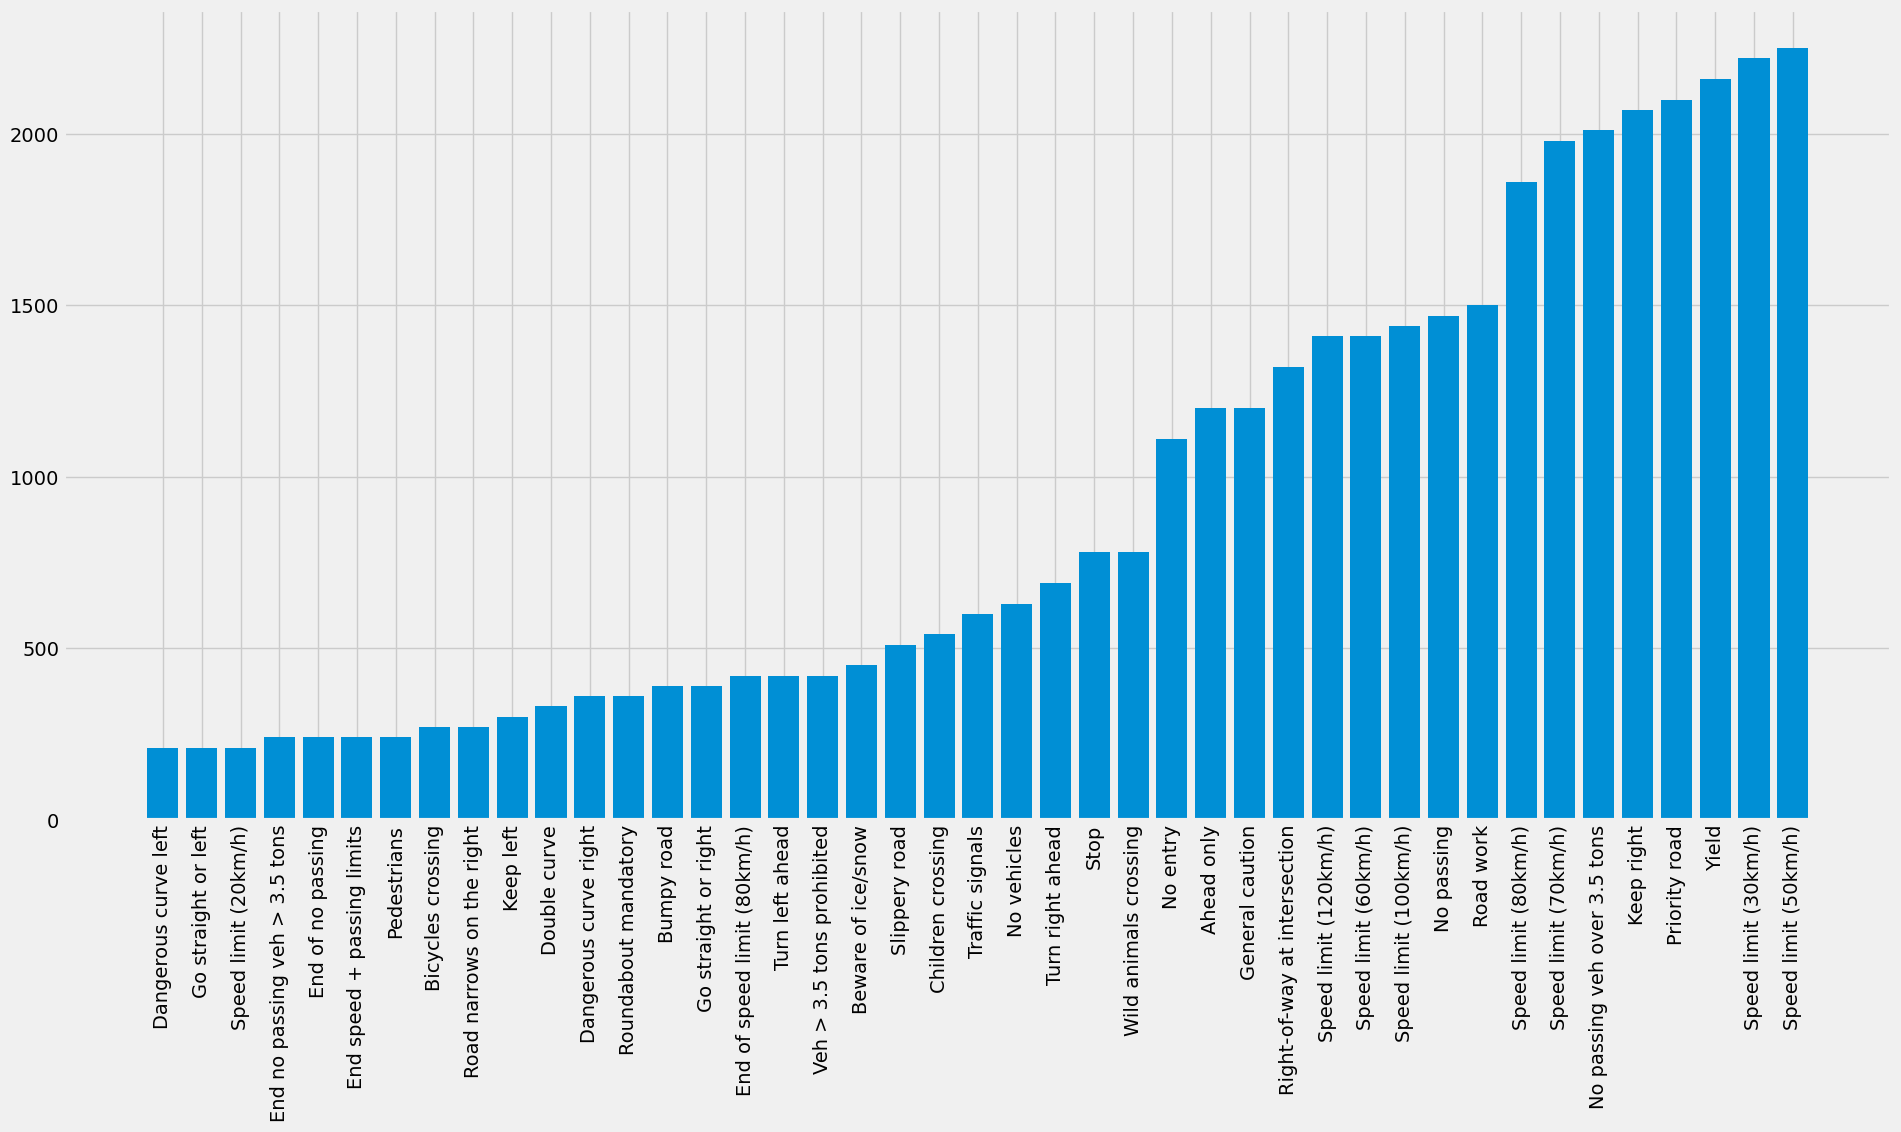

In [23]:
train_path = '/home/amber/Documents/sign/gtsrb-german-traffic-sign/Train'

folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

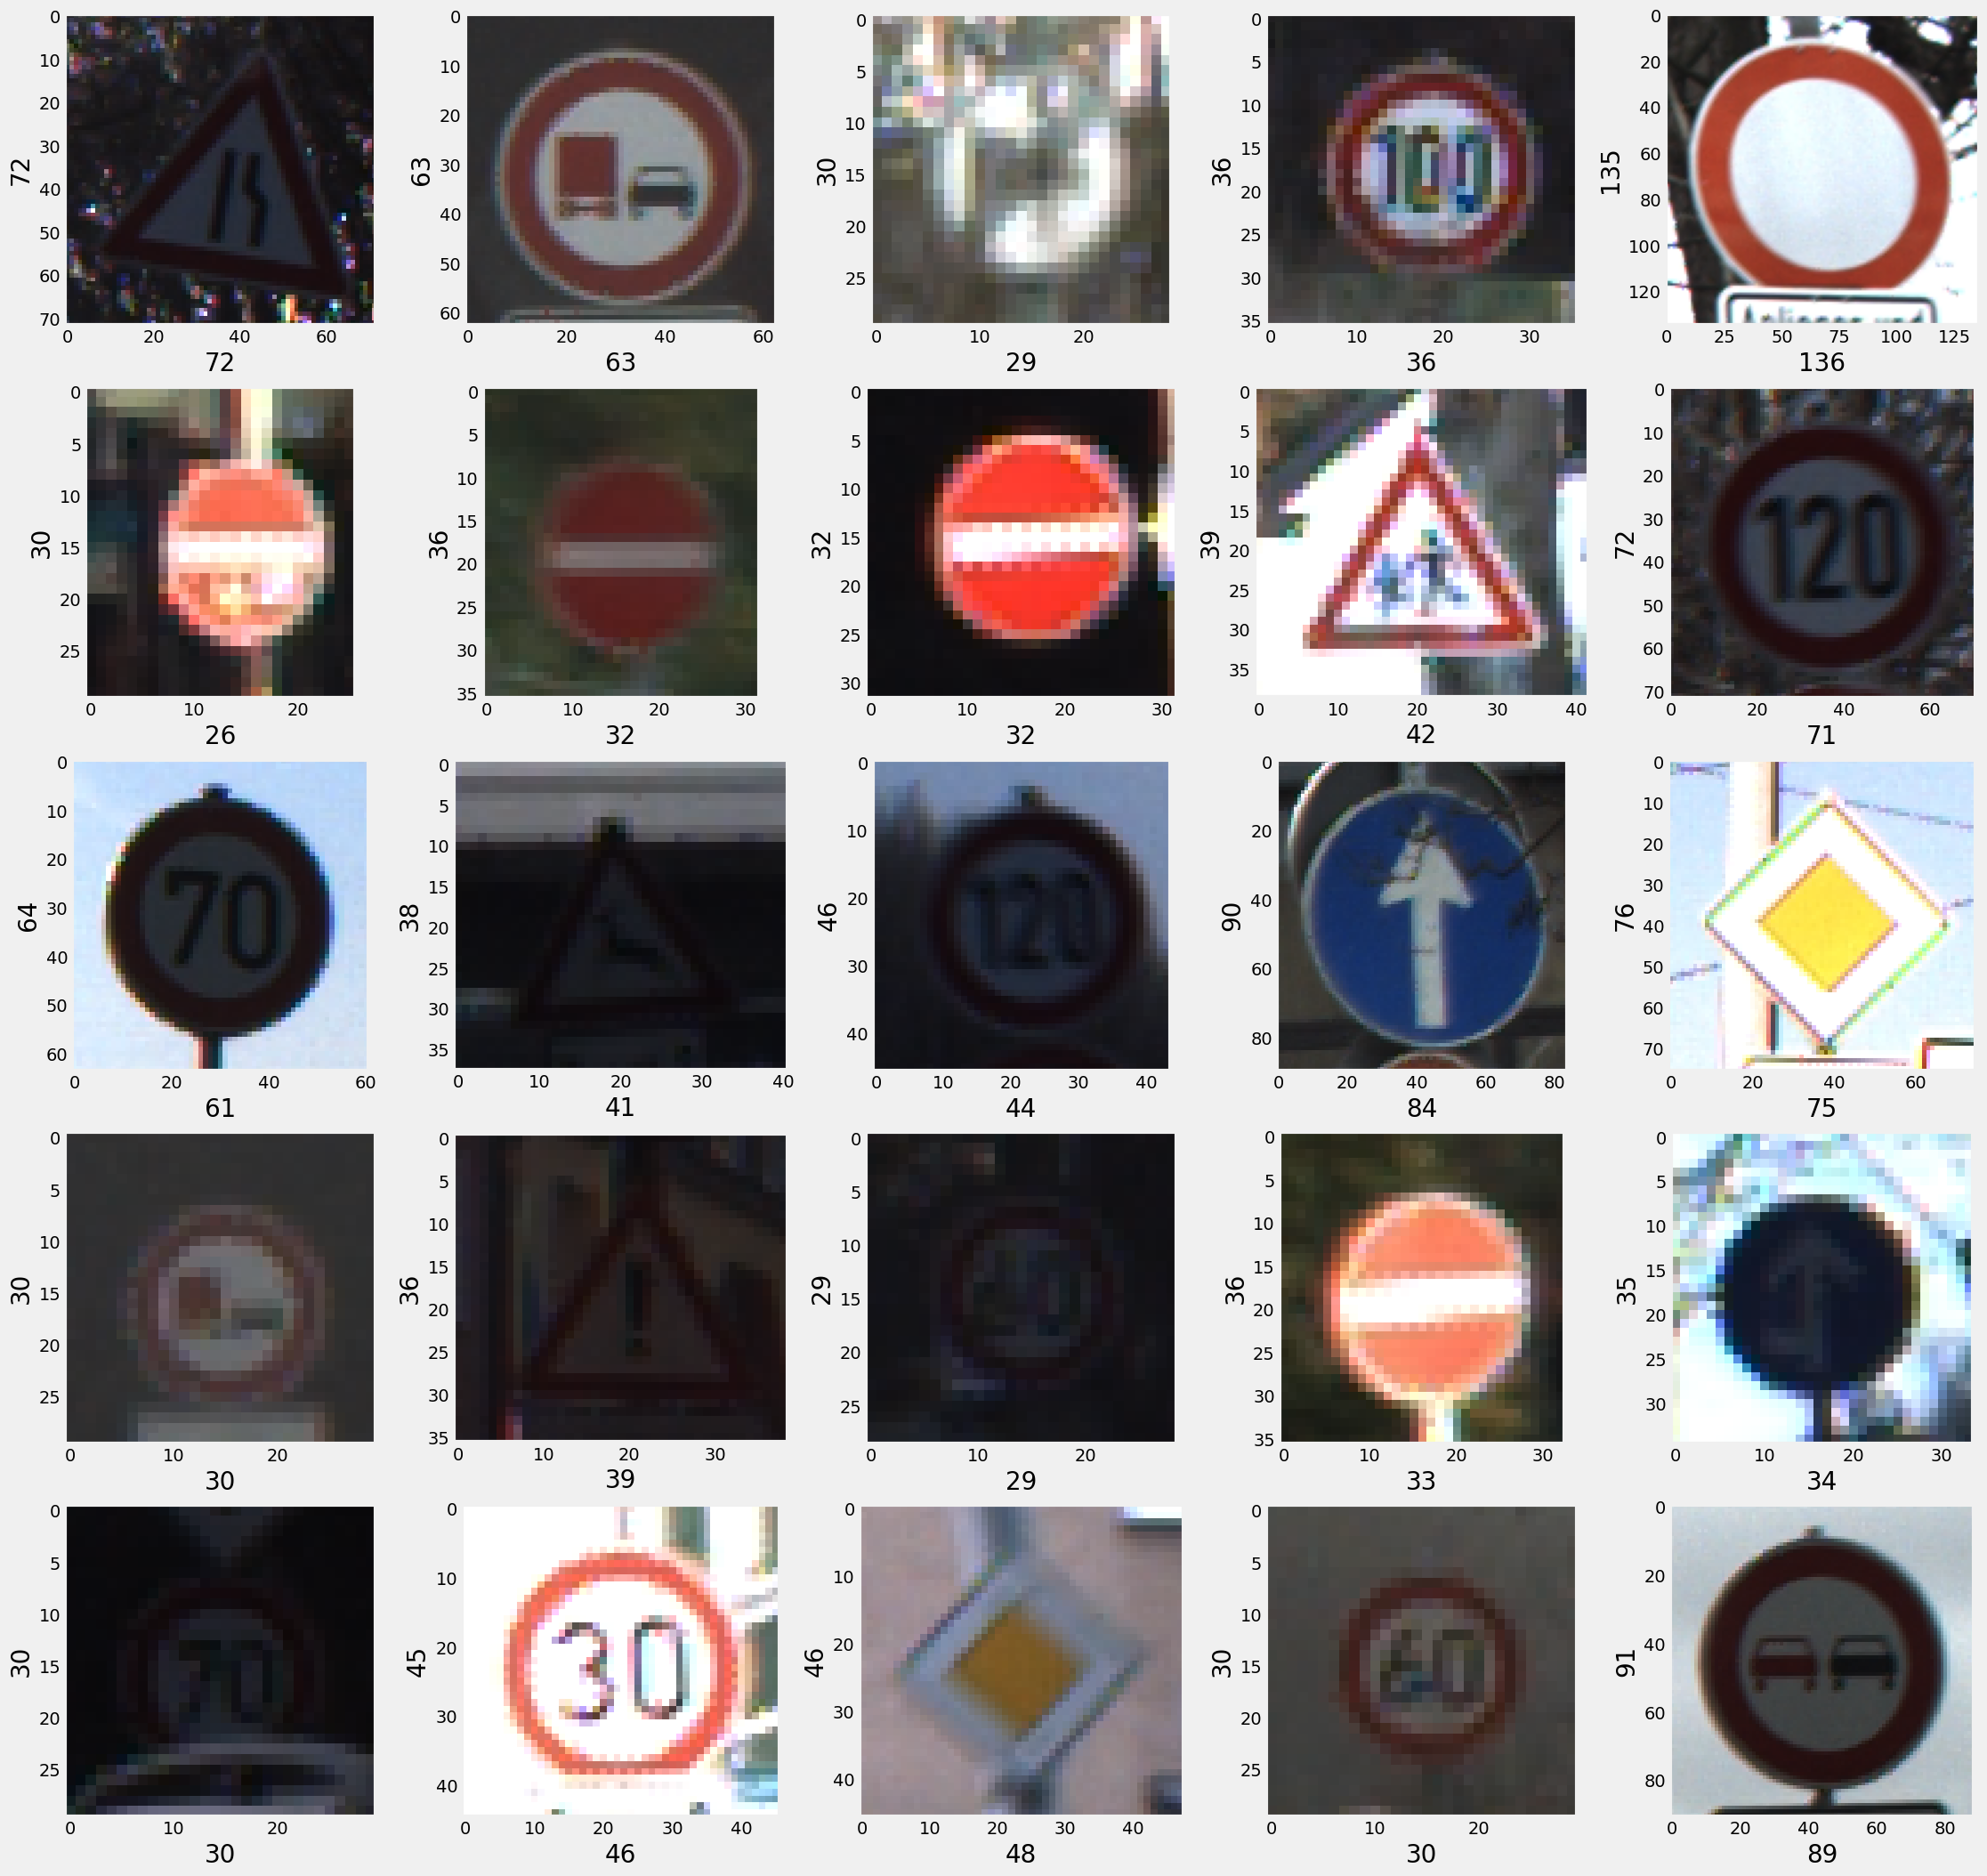

In [24]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread
data_dir = '/home/amber/Documents/sign/gtsrb-german-traffic-sign'

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid()
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

### Transforms

In [25]:
from torchvision.transforms import v2

train_transforms = v2.Compose([
#     v2.ToPILImage(),

    v2.ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1),
    v2.RandomEqualize(0.4),
    v2.AugMix(),
    v2.RandomHorizontalFlip(p=0.3),
    v2.RandomVerticalFlip(0.3),
    v2.GaussianBlur((3,3)),
    v2.RandomRotation(30),
    v2.Resize(size=(50,50)),
    v2.ToImageTensor(),


])
validation_transforms =  v2.Compose([
    v2.Resize(size=(50,50)),
    v2.ToImageTensor(),

])

In [26]:
def train_test_split(dataset,train_size):

    train_size = int(train_size * len(dataset))
    test_size = int(len(dataset) - train_size)
    return random_split(dataset,[train_size,test_size])

In [27]:
train_dataset = GTSRB(root='/home/amber/Documents/sign/gtsrb-german-traffic-sign',split="train")
train_set,validation_set = train_test_split(train_dataset,train_size=0.8)

### Transformation

In [28]:
train_set.dataset.transform = train_transforms
validation_set.dataset.transform = validation_transforms


### Dataloader

In [29]:
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_set,batch_size=BATCH_SIZE,shuffle=True)
validation_loader = DataLoader(dataset=validation_set,batch_size=BATCH_SIZE)


### Modeling

In [30]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

running on the GPU


### Model

In [31]:
class GTSRB_MODEL(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(GTSRB_MODEL,self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
      
        self.metrics = {}
        
        self.flatten = nn.Flatten()
        
        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)
       

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        

        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)


        
        self.conv5 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3)
        self.conv6 = nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3)
        self.batchnorm3 = nn.BatchNorm2d(1024)
        
       
       

        self.l1 = nn.Linear(1024*4*4,512)
        self.l2 = nn.Linear(512,128)
        self.batchnorm4 = nn.LayerNorm(128)
        self.l3 = nn.Linear(128,output_dim)
        
        
    def forward(self,input):
        
        conv = self.conv1(input)
        conv = self.conv2(conv)
        batchnorm = self.relu(self.batchnorm1(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv3(maxpool)
        conv = self.conv4(conv)
        batchnorm = self.relu(self.batchnorm2(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv5(maxpool)
        conv = self.conv6(conv)
        batchnorm = self.relu(self.batchnorm3(conv))
        maxpool = self.maxpool(batchnorm)
        
        
        flatten = self.flatten(maxpool)
        
        dense_l1 = self.l1(flatten)
        dropout = self.dropout3(dense_l1)
        dense_l2 = self.l2(dropout)
        batchnorm = self.batchnorm4(dense_l2)
        dropout = self.dropout2(batchnorm)
        output = self.l3(dropout)
        
       
        return output
    
    def training_metrics(self,positives,data_size,loss):
        acc = positives/data_size
        return loss,acc
    
    def validation_metrics(self,validation_data,loss_function):
       data_size = len(validation_data)
       correct_predictions = 0
       total_samples = 0
       val_loss = 0

       model = self.eval()
       with torch.no_grad() : 
        for step,(input,label) in enumerate(validation_data):
            input = input.to(torch.float)

            input,label = input.to(device),label.to(device)
            prediction = model.forward(input)
            loss = loss_function(prediction,label)
            val_loss = loss.item()
            _,predicted = torch.max(prediction,1)
            correct_predictions += (predicted == label).sum().item()
            total_samples += label.size(0)

       val_acc = correct_predictions/total_samples

       return val_loss,val_acc

    def history(self):
        return self.metrics

            


    def compile(self,train_data,validation_data,epochs,loss_function,optimizer,learning_rate_scheduler):
        val_acc_list = []
        val_loss_list = []

        train_acc_list = []
        train_loss_list = []

        learning_rate_list = []

        print('training started ...')
        STEPS = len(train_data)
        for epoch in range(epochs):
            lr = optimizer.param_groups[0]["lr"]
            learning_rate_list.append(lr)
            correct_predictions = 0
            total_examples = 0
            loss = 0
            with tqdm.trange(STEPS) as progress:

                for step,(input,label) in enumerate(train_loader):
                    input = input.to(torch.float)
#                     input.type()


                    input,label = input.to(device),label.to(device)
                    prediction = self.forward(input)

                    _, predicted = torch.max(prediction, 1)
                    correct_predictions += (predicted == label).sum().item()
                    total_examples += label.size(0)
                    l = loss_function(prediction,label)
                    loss = l.item()
                    l.backward()
                    optimizer.step()
                    optimizer.zero_grad()

                    progress.colour = 'green'
                    progress.desc = f'Epoch [{epoch}/{EPOCHS}], Step [{step}/{STEPS}], Learning Rate [{lr}], Loss [{"{:.4f}".format(l)}], Accuracy [{"{:.4f}".format(correct_predictions/total_examples)}]'
                    progress.update(1)

            training_loss,training_acc = self.training_metrics(correct_predictions,total_examples,loss)
            train_acc_list.append(training_acc)
            train_loss_list.append(training_loss)

            val_loss, val_acc = self.validation_metrics(validation_data,loss_function)
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)
            
            print(f'val_accuracy [{val_acc}], val_loss [{val_loss}]')

            
            learning_rate_scheduler.step()
        
        metrics_dict = {
                'train_acc':train_acc_list,
                'train_loss':train_loss_list,
                'val_acc':val_acc_list,
                'val_loss':val_loss_list,
                'learning_rate':optimizer.param_groups[0]["lr"]
            }
        self.metrics = metrics_dict
        print('training complete !')    

        

In [32]:
import tqdm
EPOCHS = 10
LEARNING_RATE = 0.0008
INPUT_DIM = 3*50*50
OUTPUT_DIM = 43
model = GTSRB_MODEL(INPUT_DIM,OUTPUT_DIM).to(device)

optimizer = Adam(params=model.parameters(),lr=LEARNING_RATE)
lr_s = lr_scheduler.LinearLR(optimizer,start_factor=1.0,end_factor=0.5,total_iters=10)
loss = nn.CrossEntropyLoss()


In [33]:
model.compile(train_data=train_loader,
              validation_data=validation_loader,
              epochs=EPOCHS,
              loss_function=loss,
              optimizer=optimizer,
              learning_rate_scheduler=lr_s)

training started ...


Epoch [0/10], Step [490/491], Learning Rate [0.0008], Loss [0.0869], Accuracy [0.6979]: 100%|██████████| 491/491 [04:33<00:00,  1.80it/s]


val_accuracy [0.9846977811782709], val_loss [0.041438426822423935]


Epoch [1/10], Step [490/491], Learning Rate [0.00076], Loss [0.0062], Accuracy [0.9923]: 100%|██████████| 491/491 [00:31<00:00, 15.68it/s]


val_accuracy [0.9931140015302219], val_loss [0.03216826170682907]


Epoch [2/10], Step [490/491], Learning Rate [0.00072], Loss [0.0142], Accuracy [0.9977]: 100%|██████████| 491/491 [00:29<00:00, 16.39it/s]


val_accuracy [0.9881407804131599], val_loss [0.005272072274237871]


Epoch [3/10], Step [490/491], Learning Rate [0.00068], Loss [0.0005], Accuracy [0.9993]: 100%|██████████| 491/491 [00:30<00:00, 16.12it/s]


val_accuracy [0.9982147411374649], val_loss [0.0009279334335587919]


Epoch [4/10], Step [490/491], Learning Rate [0.00064], Loss [0.0001], Accuracy [1.0000]: 100%|██████████| 491/491 [00:30<00:00, 15.97it/s]


val_accuracy [0.998342259627646], val_loss [0.00044406112283468246]


Epoch [5/10], Step [490/491], Learning Rate [0.0006000000000000001], Loss [0.0002], Accuracy [1.0000]: 100%|██████████| 491/491 [00:30<00:00, 15.94it/s]


val_accuracy [0.9984697781178271], val_loss [0.00029654920217581093]


Epoch [6/10], Step [490/491], Learning Rate [0.0005600000000000001], Loss [0.0001], Accuracy [1.0000]: 100%|██████████| 491/491 [00:30<00:00, 16.24it/s]


val_accuracy [0.9987248150981892], val_loss [0.00022417331638280302]


Epoch [7/10], Step [490/491], Learning Rate [0.0005200000000000001], Loss [0.0002], Accuracy [1.0000]: 100%|██████████| 491/491 [00:30<00:00, 16.20it/s]


val_accuracy [0.9987248150981892], val_loss [0.00016827869694679976]


Epoch [8/10], Step [490/491], Learning Rate [0.00048000000000000007], Loss [0.0001], Accuracy [1.0000]: 100%|██████████| 491/491 [00:30<00:00, 15.90it/s]


val_accuracy [0.9987248150981892], val_loss [0.00013030109403189272]


Epoch [9/10], Step [490/491], Learning Rate [0.00044000000000000007], Loss [0.0001], Accuracy [1.0000]: 100%|██████████| 491/491 [00:30<00:00, 16.23it/s]


val_accuracy [0.9987248150981892], val_loss [0.0001134133999585174]
training complete !


In [38]:
# saving a checkpoint assuming the network class named ClassNet
checkpoint = {'model': model,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'epoch': EPOCHS,
              'loss': loss,}

torch.save(checkpoint, 'checkpoint.pkl')



In [74]:
import torch
# Loading model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)

    model = checkpoint['model']  # 提取网络结构
    model.load_state_dict(checkpoint['model_state_dict'])  # 加载网络权重参数
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # 加载优化器参数
    # epoch = checkpoint['epoch']
    # loss = checkpoint['loss']

    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()

    return model

trained_model = load_checkpoint('/home/amber/Documents/sign/model/checkpoint.pkl')

In [62]:
transforms = v2.Compose([
    v2.Resize(size=(50,50)),
    v2.ToImageTensor(),

])

In [71]:
test_dataset = GTSRB(root='/home/amber/Documents/sign/gtsrb-german-traffic-sign',split='test',transform=transforms)
test_dataloader = DataLoader(dataset = test_dataset)
print(test_dataloader)

In [72]:
from sklearn.metrics import accuracy_score

y_pred = []
y_true = []
trained_model = trained_model.eval().to(device)
with tqdm.tqdm(colour='red',total=len(test_dataloader)) as progress:
  
  with torch.no_grad() : 
    for id,(input,label) in enumerate(iter(test_dataloader)):
        input = input.to(torch.float)
        input,label = input.to(device),label
        y_true = label.cpu().detach().numpy()
        
        prediction = trained_model.forward(input)
        _,prediction = torch.max(prediction,1)
        y_pred = prediction.cpu().detach().numpy()
        
        progress.desc = f'Test Accuracy : {accuracy_score(y_true,y_pred)} '
        progress.update(1)
        

        

Test Accuracy : 1.0 : 100%|██████████| 12630/12630 [00:22<00:00, 561.79it/s]
